<a href="https://www.kaggle.com/code/mrsalty/cve-severity-classification-ml-nlp-and-mlp?scriptVersionId=242505460" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CVE Severity Classification: ML, NLP and MLP

## 

## Introduction

**Common Vulnerabilities and Exposures (CVEs)** are standardized identifiers for publicly disclosed cybersecurity flaws, providing essential information about vulnerabilities in both software and hardware. Each CVE record includes a detailed description of the flaw, lists of affected products, and **Severity Scores (CVSS)** that assist in prioritizing remediation efforts. While CVSS ratings can be updated as new exploit techniques are discovered, the original CVE descriptions remain unchanged, even as subsequent findings add further context.

Accurately predicting CVE severity is crucial for organizations to proactively manage risks, especially when dealing with **newly identified vulnerabilities** that have not yet been officially rated. Reliable early predictions can help security teams allocate resources more effectively, accelerate patching of critical systems, and mitigate zero-day threats. Traditional methods often treat CVE descriptions as generic text without capturing the underlying technical nuances and tend to overlook structured metadata such as attack complexity or vendor patches.

## Objective
The aim of this project is to conduct a comparative study of Machine Learning, Deep Learning models and NLP techniques for predicting CVE severity, with a potential hybrid approach. Specifically, the study focuses on:

* **Machine Learning models** - Models used as baseline for benchmarking.

* **Deep Learning (MLP)** - Exploring the effectiveness of a custom Multi-Layer Perceptron (MLP) for utilizing structured data in CVE severity prediction.

* **NLP Techniques** - Evaluating the performance of LSTM and Transformer-based models in analyzing textual descriptions from CVE records.

* **Hybrid Approach** - Investigating the combination of deep learning models for structured data and NLP models for text, to enhance the prediction of CVE severity.

The project aims to compare the performance of these approaches, determining the relative strengths of each technique, and exploring the potential for integrating them into a unified model for better risk assessment and decision-making in cybersecurity.

By combining these data modalities, the project seeks to enhance the accuracy of CVE severity predictions, thereby providing improved risk assessments for cybersecurity teams.

## Approach

1. **Textual Data Processing**: Preprocess the CVE descriptions using techniques like tokenization and transformer-based embeddings (e.g. RoBERTa).  
2. **Structured Data Processing**: Normalize and encode numerical and categorical features.  
3. **Baseline ML Models**: Implement standard machine learning models, such as a Dummy Classifier, Linear Regression, Random Forest, and XGBoost, for performance comparison with the proposed model.  
4. **Deep Learning (MLP)**: Develop a deep dense network that utilizes only categorical and numerical data.  
5. **Embedding-Only LSTM Model**: Build an LSTM network that leverages the CVE description exclusively.  
6. **Embedding-Only Transformer Model**: Train a transformer-based model using only the CVE description text.  
7. **Combined Deep Learning (MLP) with NLP Model**: Create a hybrid model that integrates dense layers for structured data with NLP module for processing text.  
8. **Evaluation**: Evaluate model performance using metrics such as  **Accuracy**, **F1-score**, **Macro F1-score** and benchmark these against the baseline models.

### What are Common Vulnerabilities Exposures (CVEs)

A **CVE (Common Vulnerabilities and Exposures)** is a publicly disclosed security vulnerability assigned a unique identifier. The **CVE system** is maintained by [MITRE Corporation](https://cve.mitre.org/) and is used to standardize the identification and tracking of vulnerabilities across different security tools and databases.  

#### **CVE Structure**
Each CVE entry follows a specific format:  

```
CVE-YYYY-NNNNN  
```
- **CVE:** Prefix indicating it's a CVE entry.  
- **YYYY:** Year the vulnerability was assigned.  
- **NNNNN:** A unique identifier (5+ digits).  


#### **CVE Components**
Each CVE entry includes:  

##### 1. **Metrics** (The labeled data)
Describe how severe the vulnerability is using the **CVSS** scoring system. It includes:
- How easy it is to exploit (e.g., requires physical access or can be done remotely)
- How much it can impact confidentiality, integrity, and availability
- A numerical `Severity score`, e.g., 6.7 = Medium, where the range of values is `Low`, `Medium`, `High` and `Critical` severity.

**NOTE:** This data section was excluded from model training because it contains not only the target labels (`Severity`) but also features that are highly correlated with those labels, such as `Attack Vector`, `Attack Complexity`, etc.

##### 2. **Weaknesses**
Lists the type of **coding or design flaw** that caused the vulnerability, using **CWE** codes.  
Example: `CWE-319` means information is transmitted in cleartext, which can be intercepted.

##### 3. **Configurations**
Specifies which **products, versions, and platforms** are affected.  
Uses **CPEs** (standardized product names) and version ranges to pinpoint what’s vulnerable.

#### 4. **References**
Contains **links to external resources** like:
- Vendor advisories
- Official documentation
- Further technical details

## Download CVE data

We use a convenient [GitHub repository](https://github.com/justakazh/CVE_Database) to download all CVE data from year 1999. The repository is an up to date storage aligned with [NIST](https://nvd.nist.gov/), a U.S. government repository of standards based vulnerability management data.



In [1]:
!pip install hf_xet
!pip install imbalanced-learn scikit-learn
!pip install wordcloud
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 91.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
working_dir = '/kaggle/working/CVE_Database'

In [3]:
import os

# Clone from Github repository with all historical NIST CVE data
if not os.path.exists(working_dir):
  !git clone https://github.com/justakazh/CVE_Database

Cloning into 'CVE_Database'...
remote: Enumerating objects: 532798, done.
remote: Counting objects: 100% (520/520), done.
remote: Compressing objects: 100% (344/344), done.
remote: Total 532798 (delta 450), reused 233 (delta 176), pack-reused 532278 (from 1)
Receiving objects: 100% (532798/532798), 523.93 MiB | 33.99 MiB/s, done.
Resolving deltas: 100% (524092/524092), done.
Updating files: 100% (246994/246994), done.


## Feature Engineering

Let's import data into a DataFrame and manipulate data to obtain best results.


### Load data into DataFrame

The data is organized into folders by year, with each folder containing a JSON file for each CVE. Since the structure is hierarchical rather than flat, a mapping process is required to transform the CVE data into a flat format for insertion into our DataFrame.

** Note that **CVSS score** related fields (such as Attack Vector, Attack Complexity, Privileges Required, User Interaction, etc) have been ignored as they are **highly correlated with the definition of the Severity level**, so they would leak critical information into the model.

Here's a  brief description of the fields related to a CVE which have been used for the model training.

#### Target Variable:
- `Severity`: The risk level or severity of the CVE, typically categorized as Low, Medium, High, or Critical.

#### Core Features:
- `Description` : A textual description of the vulnerability, explaining the issue and its potential impact.  
- `Problem_Type` : The type of problem or vulnerability (e.g., buffer overflow, SQL injection).  
- `Vuln_Status` : Current status of the CVE (e.g., "Not Affected," "Resolved").  
- `Source_Identifier` : A unique identifier or reference to the source that reported or tracked the CVE.  
- `Published_Date` : The date the CVE was first published and made publicly available.  
- `Last_Modified_Date` : The date when the CVE details were last modified or updated.  
- `Time_Delta_Days` : The number of days between the published date and the current date, representing how long the CVE has been active.  
- `Affected_Products_Count` : The number of products or software versions affected by the CVE.  
- `Affected_Vendors` : A list of vendors or companies whose products are affected by the CVE.  
- `Affected_Product_Names` : Names of the affected products.  
- `Affected_Versions` : The specific versions of the products affected by the CVE.  
- `Config_Operators_AND` : The count of AND logical operators found in the configuration or exploit instructions related to the CVE.  
- `Config_Operators_OR` : The count of OR logical operators found in the configuration or exploit instructions.  
- `Config_Negate_Count` : The number of negations or NOT operators in the configuration.  
- `Config_Total_Nodes` : The total number of nodes or entities involved in the configuration of the vulnerability.  
- `References_Count` : The number of references or links associated with the CVE, such as patches, discussions, or other related resources.  
- `Reference_Tags` : A dictionary of tags or labels associated with each reference, such as "security advisory," "patch," etc.  

In [4]:
import re
import json
import pandas as pd
from datetime import datetime
from collections import defaultdict

def parse_cvss_version(key):
    """Extract numerical version from CVSS metric key (e.g., 'cvssMetricV31' -> 3.1)."""
    version_str = key.replace("cvssMetricV", "").replace("_", "")
    if not version_str:
        return 0.0
    major = version_str[0]
    minor = version_str[1:] if len(version_str) > 1 else "0"
    return float(f"{major}.{minor}")

def process_cve_file(file_path):#
    """Process a single CVE file and extract relevant information."""
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    cve_data = data.get("cve", {})

    # Extract target variable (severity) from CVSS
    severity = None
    metrics = cve_data.get("metrics", {})
    cvss_keys = [k for k in metrics.keys() if k.startswith("cvssMetricV")]

    if cvss_keys:
        highest_version_key = cvss_keys[0]
        if metric_entries := metrics.get(highest_version_key, []):
            primary_entry = next(
                (e for e in metric_entries if e.get("type") == "Primary"),
                metric_entries[0]
            )
            cvss_data = primary_entry.get("cvssData", {})
            data_version = cvss_data.get("version")

            if data_version and data_version.startswith("3."):
                severity = cvss_data.get("baseSeverity")
            elif data_version and data_version.startswith("2."):
                severity = cvss_data.get("severity")

    # Textual description
    description = next(
        (d["value"] for d in cve_data.get("descriptions", [])
         if d["lang"] == "en"), None
    )

    # Weakness types (CWE IDs)
    problem_types = set()
    for weakness in cve_data.get("weaknesses", []):
        for desc in weakness.get("description", []):
            if desc.get("lang") == "en":
                problem_types.add(desc.get("value"))
    problem_type = ", ".join(sorted(problem_types)) if problem_types else None

    # Affected products analysis
    affected_products = []
    for config in cve_data.get("configurations", []):
        for node in config.get("nodes", []):
            affected_products.extend(
                [cpe["criteria"] for cpe in node.get("cpeMatch", [])
                 if cpe.get("vulnerable")]
            )

    vendors, products, versions = set(), set(), set()
    for criteria in affected_products:
        parts = criteria.split(":")
        if len(parts) >= 5:
            vendors.add(parts[3])
            products.add(parts[4])
            if len(parts) >= 6: versions.add(parts[5])

    # Reference analysis
    tags_counter = defaultdict(int)
    for ref in cve_data.get("references", []):
        for tag in ref.get("tags", []):
            tags_counter[tag] += 1

    # Configuration complexity analysis
    operator_counts = defaultdict(int)
    negate_count = 0
    total_nodes = 0
    for config in cve_data.get("configurations", []):
        if op := config.get("operator"):
            operator_counts[op] += 1
        nodes = config.get("nodes", [])
        total_nodes += len(nodes)
        for node in nodes:
            if op := node.get("operator"):
                operator_counts[op] += 1
            if node.get("negate", False):
                negate_count += 1

    # Temporal features
    time_delta_days = None
    if (published := cve_data.get("published")) and \
       (last_modified := cve_data.get("lastModified")):
        try:
            pub_date = datetime.fromisoformat(published)
            mod_date = datetime.fromisoformat(last_modified)
            time_delta_days = (mod_date - pub_date).days
        except ValueError:
            pass

    return {
        # Target variable
        "Severity": severity,

        # Core features
        "Description": description,
        "Problem_Type": problem_type,
        "Vuln_Status": cve_data.get("vulnStatus"),
        "Source_Identifier": cve_data.get("sourceIdentifier"),

        # Temporal features
        "Published_Date": published,
        "Last_Modified_Date": last_modified,
        "Time_Delta_Days": time_delta_days,

        # Product analysis
        "Affected_Products_Count": len(affected_products),
        "Affected_Vendors": ", ".join(sorted(vendors)) if vendors else None,
        "Affected_Product_Names": ", ".join(sorted(products)) if products else None,
        "Affected_Versions": ", ".join(sorted(versions)) if versions else None,

        # Configuration complexity
        "Config_Operators_AND": operator_counts.get("AND", 0),
        "Config_Operators_OR": operator_counts.get("OR", 0),
        "Config_Negate_Count": negate_count,
        "Config_Total_Nodes": total_nodes,

        # Reference analysis
        "References_Count": len(cve_data.get("references", [])),
        "Reference_Tags": dict(tags_counter)
    }

def load_cve_data(repo_path):
    cve_data_list = []
    for root, _, files in os.walk(repo_path):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                try:
                    cve_entry = process_cve_file(file_path)
                    cve_data_list.append(cve_entry)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    df = pd.DataFrame(cve_data_list).replace([None], pd.NA)
    return df

df = load_cve_data(working_dir)
df["Published_Date"] = pd.to_datetime(df["Published_Date"])
df["Last_Modified_Date"] = pd.to_datetime(df["Last_Modified_Date"])
#df.to_csv('cve-list.csv', index=False)

### Versions

We normalize version strings in the `Affected_Versions` column of a DataFrame, handling wildcards, Microsoft-style versions, and numeric patterns.

In [5]:
def clean_version(v):
    """Normalize common invalid version patterns"""
    if pd.isna(v):
        return "unknown"

    v = str(v).lower().strip()

    # Handle wildcards and placeholders
    if v in ["*", "-", "all"]:
        return "all_versions"

    # Handle Microsoft-style versions (e.g., 20h2)
    if re.match(r"^\d{2}[a-z]\d$", v):
        return f"win_{v}"

    # Extract numeric components from complex strings
    if matches := re.findall(r"\d+", v):
        return "v" + "_".join(matches[:3])  # Keep first 3 numbers

    return "other"

# Apply cleaning
df['Cleaned_Versions'] = (
    df['Affected_Versions']
    .str.split(', ')
    .explode()
    .apply(clean_version)
    .groupby(level=0)
    .agg(list)
)
df = df.drop(columns=['Affected_Versions'])

### Vendors

We now process a column of comma-separated vendor names, keeping the top N (500) most frequent vendors and grouping others as "Other". We then calculate and assign a frequency score to each row based on the average occurrence of the vendors in the processed list.

In [6]:
# Calculate vendor frequencies
vendor_counts = df['Affected_Vendors'].str.split(', ').explode().value_counts()

# Keep top N vendors and group others as "Other"
top_vendors = vendor_counts.head(500).index.tolist()
df['Vendors_Processed'] = (
    df['Affected_Vendors']
    .fillna('')  # Replace NaN/NA with an empty string
    .str.split(', ')
    .apply(lambda x: [v if v in top_vendors else 'Other' for v in x] if isinstance(x, list) else [])  # Check type before iteration
    .str.join(', ')
)

# Calculate global vendor frequencies
vendor_freq = df['Vendors_Processed'].str.split(', ').explode().value_counts(normalize=True)

# Encode vendor lists as average frequency
df['Vendor_Freq_Score'] = (
    df['Vendors_Processed']
    .str.split(', ')
    .apply(lambda x: sum(vendor_freq.get(v, 0) for v in x) / len(x) if x else 0)
)

### Problem Types

We now and filter the `Problem_Type` column to keep the top most frequent problem types, flag any "other" types, and apply multi-hot encoding to create binary columns for the top problem types. We then add these encoded columns and the "other" flag back to the DataFrame.

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Max problem types (columns)
TOP_N_PROBLEM_TYPES = 20

# Split the 'Problem_Type' column into a list of problem types
df["Problem_Type_List"] = df["Problem_Type"].str.split(',')

# Flatten the list of all problem types and count their frequency
problem_types = df["Problem_Type_List"].explode().str.strip()

# Get the top N most frequent problem types
top_problem_types = problem_types.value_counts().head(TOP_N_PROBLEM_TYPES).index

# Ensure top_problem_types is a set for fast lookup
top_set = set(top_problem_types)

# Filter out only the top problem types and detect if there's any "other"
def filter_and_flag_others(problems):
    if not isinstance(problems, list):
        return [], 0
    cleaned = [p.strip() for p in problems]
    filtered = [p for p in cleaned if p in top_set]
    others_flag = int(any(p not in top_set for p in cleaned))
    return filtered, others_flag

# Apply filtering and flagging
df[["Filtered_Problem_Type_List", "CWE_Others"]] = df["Problem_Type_List"].apply(
    lambda x: pd.Series(filter_and_flag_others(x))
)

# Initialize MultiLabelBinarizer to create multi-hot encoding
mlb = MultiLabelBinarizer(classes=top_problem_types)
problem_type_encoded = mlb.fit_transform(df["Filtered_Problem_Type_List"])

# Convert the result into a DataFrame with column names as top problem types
problem_type_df = pd.DataFrame(problem_type_encoded, columns=mlb.classes_, index=df.index)

# Add the multi-hot encoded columns and CWE_Others back to the original dataframe
df = pd.concat([df, problem_type_df, df["CWE_Others"]], axis=1)

# Drop temporary columns
df = df.drop(columns=["Problem_Type_List", "Filtered_Problem_Type_List", "CWE_Others"])

### Reference Tags

We now extract key-value pairs from the `Reference_Tags` JSON column in a DataFrame, normalizes and clean the keys into separate prefixed columns, then merge them back into the original DataFrame. Missing values are filled with 0 and all values are converted to integers.

In [8]:
# Extract Reference Tags key/values and store each in separate column
reference_tags_df = pd.json_normalize(df["Reference_Tags"])

# Clean and prefix column names
reference_tags_df = reference_tags_df.rename(
    columns=lambda x: f"Reference_Tag_{x.replace(' ', '_').lower()}"
).fillna(0).astype(int)

# Merge with original DataFrame
df = pd.concat([
    df.drop(columns=["Reference_Tags"]),  # Remove original column
    reference_tags_df
], axis=1)

### Affected Products

Let's identify the top N most frequent product names from the `Affected_Product_Names` column, then creates binary columns indicating their presence per row and counts how many other (non-top) products are also present.

In [9]:
# Get only the top N Product Names
TOP_N_PRODCT_NAMES = 20

# Get top N product names
top_products = (
    df["Affected_Product_Names"]
    .str.split(', ')
    .explode()
    .value_counts()
    .head(TOP_N_PRODCT_NAMES)
    .index.tolist()
)

# Precompute product sets for each row
product_sets = df["Affected_Product_Names"].str.split(', ').apply(
    lambda x: set(p.strip() for p in x) if isinstance(x, list) else set()
)

# Create binary features
for product in top_products:
    df[f"Prod_{product}"] = product_sets.apply(lambda s: 1 if product in s else 0)

# Count others
df["Prod_Others_Count"] = product_sets.apply(
    lambda s: len(s - set(top_products)) if s else 0
)

In [10]:
# Create aggregated features for Affected_Products
df["Prod_Total_Count"] = df["Affected_Product_Names"].fillna("").str.split(', ').apply(len)
df["Prod_Has_Multiple"] = (df["Prod_Total_Count"] > 1).astype(int)
df = df.drop(columns=["Affected_Product_Names"])

In [11]:
# Create aggregated features for Affected_Versions
df["Cleaned_Versions"] = df["Cleaned_Versions"].fillna("").apply(
    lambda x: x if isinstance(x, list) else []
)

# Create Versions_All column
df["Versions_All"] = df["Cleaned_Versions"].apply(
    lambda x: 1 if "all_versions" in x else 0
)

# Create Versions_Count column (excluding "all_versions")
df["Versions_Count"] = df["Cleaned_Versions"].apply(
    lambda x: len([v for v in x if v != "all_versions"])
)
df = df.drop(columns=["Cleaned_Versions"])

### Drop NaNs

In [12]:
# Drop all rows with any NaN values
df = df.dropna()

In [13]:
df.head()

,Severity,Description,Problem_Type,Vuln_Status,Source_Identifier,Published_Date,Last_Modified_Date,Time_Delta_Days,Affected_Products_Count,Affected_Vendors,...,Prod_windows_8.1,Prod_enterprise_linux_desktop,Prod_windows_rt_8.1,Prod_enterprise_linux_server,Prod_leap,Prod_Others_Count,Prod_Total_Count,Prod_Has_Multiple,Versions_All,Versions_Count
97,HIGH,SkyStream EMR5000 1.16 through 1.18 does not d...,CWE-476,Modified,cve@mitre.org,2002-12-31 05:00:00,2024-11-20 23:42:25.017,7995,3,skystream,...,0,0,0,0,0,1,1,0,0,3
100,MEDIUM,Sharp Zaurus PDA SL-5000D and SL-5500 uses a s...,CWE-326,Modified,cve@mitre.org,2002-12-31 05:00:00,2024-11-20 23:42:33.970,7995,2,sharp,...,0,0,0,0,0,2,2,1,1,0
113,HIGH,phpRank 1.8 stores the administrative password...,CWE-312,Modified,cve@mitre.org,2002-12-31 05:00:00,2024-11-20 23:42:09.400,7995,1,phprank,...,0,0,0,0,0,1,1,0,0,1
172,CRITICAL,The decompression algorithm in zlib 1.1.3 and ...,CWE-415,Modified,cve@mitre.org,2002-03-15 05:00:00,2024-11-20 23:38:12.263,8286,1,zlib,...,0,0,0,0,0,1,1,0,1,0
266,HIGH,The Network Attached Storage (NAS) Administrat...,CWE-319,Modified,cve@mitre.org,2002-12-31 05:00:00,2024-11-20 23:42:30.113,7995,1,iomega,...,0,0,0,0,0,1,1,0,1,0


## Exploratory Data Analysis (EDA)

Let's explore and plot some data.

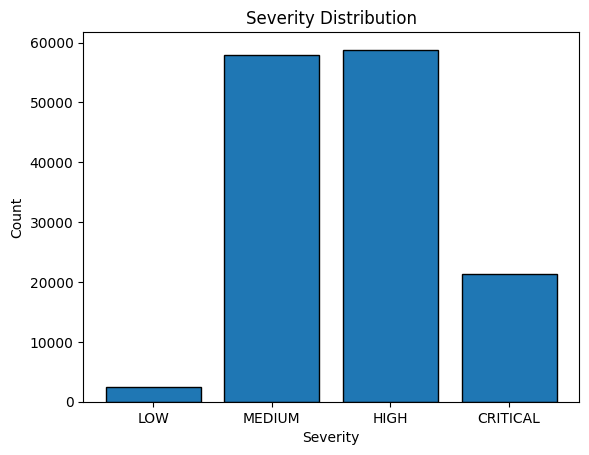

In [14]:
import matplotlib.pyplot as plt

# Define the desired severity order
severity_order = ["LOW", "MEDIUM", "HIGH", "CRITICAL"]

# Count occurrences and reorder manually
severity_counts = df["Severity"].value_counts()
severity_counts = {key: severity_counts.get(key, 0) for key in severity_order}  # Ensure all severities are included

# Plot using bar chart to enforce order
plt.bar(severity_counts.keys(), severity_counts.values(), edgecolor="black")

plt.xlabel("Severity")
plt.ylabel("Count")
plt.title("Severity Distribution")
plt.show()


As we can observe data is quite unbalanced, we will adopt a rebalancing strategy for training, specifically using SMOTE library.

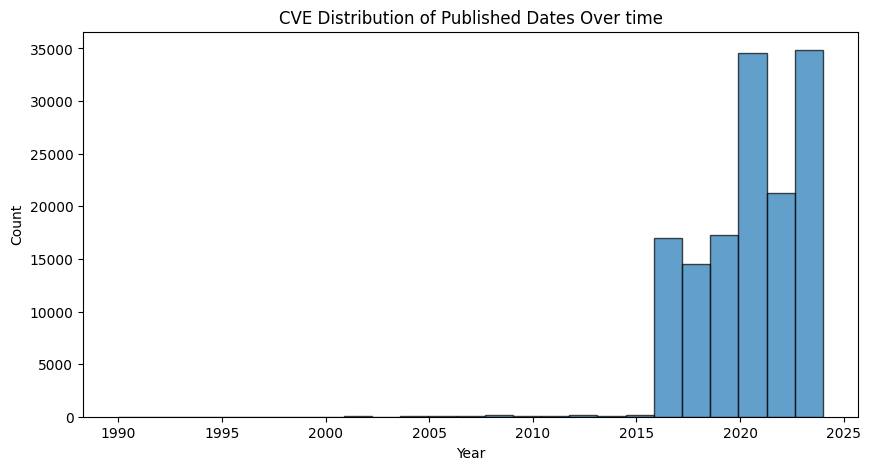

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the column is in datetime format
df["Published_Date"] = pd.to_datetime(df["Published_Date"], errors='coerce')

# Extract the year
df["Year"] = df["Published_Date"].dt.year

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(df["Year"].dropna(), bins=25, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("CVE Distribution of Published Dates Over time")

plt.show()

CVE publication is exploding in the most recent years.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


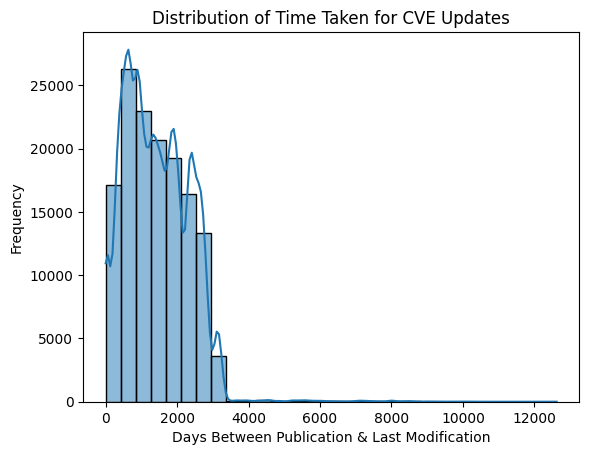

In [16]:
import seaborn as sns

sns.histplot(df["Time_Delta_Days"], bins=30, kde=True)
plt.title("Distribution of Time Taken for CVE Updates")
plt.xlabel("Days Between Publication & Last Modification")
plt.ylabel("Frequency")
plt.show()

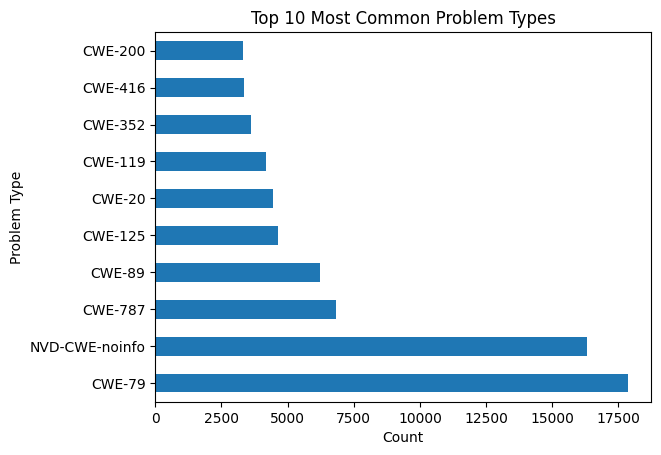

In [17]:
df["Problem_Type"].value_counts().nlargest(10).plot(kind="barh")
plt.title("Top 10 Most Common Problem Types")
plt.xlabel("Count")
plt.ylabel("Problem Type")
plt.show()

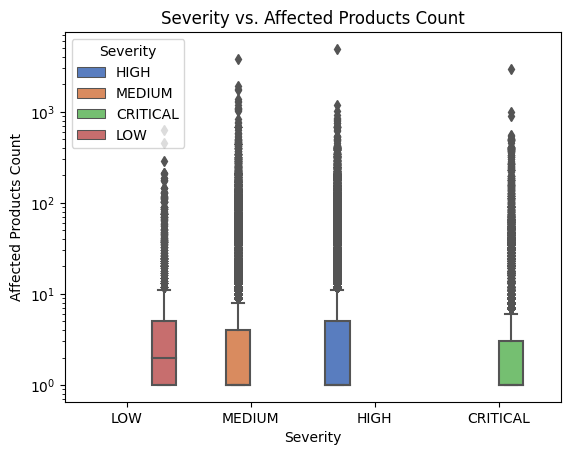

In [18]:
sns.boxplot(data=df, x="Severity", y="Affected_Products_Count", order=["LOW", "MEDIUM", "HIGH", "CRITICAL"], palette="muted", hue="Severity")
plt.xlabel("Severity")
plt.ylabel("Affected Products Count")
plt.title("Severity vs. Affected Products Count")
plt.yscale("log")
plt.show()

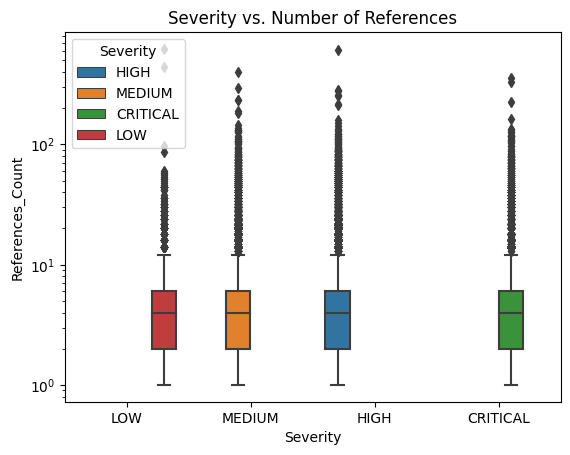

In [19]:
sns.boxplot(data=df, x="Severity", y="References_Count", order=["LOW", "MEDIUM", "HIGH", "CRITICAL"], hue="Severity")
plt.title("Severity vs. Number of References")
plt.yscale("log")
plt.show()

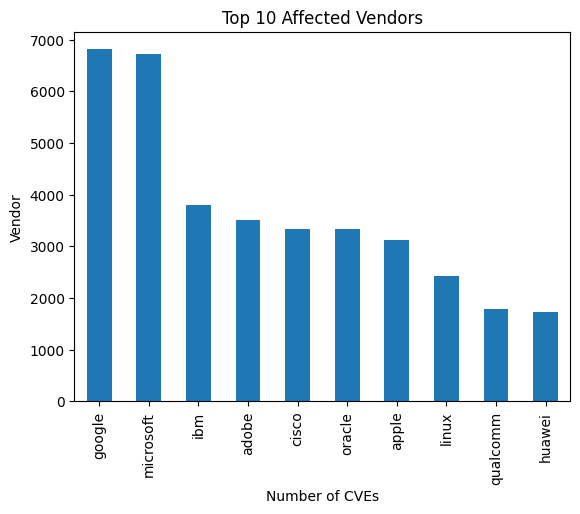

In [20]:
df["Affected_Vendors"].explode().value_counts().nlargest(10).plot(kind="bar")
plt.title("Top 10 Affected Vendors")
plt.ylabel("Vendor")
plt.xlabel("Number of CVEs")
plt.show()

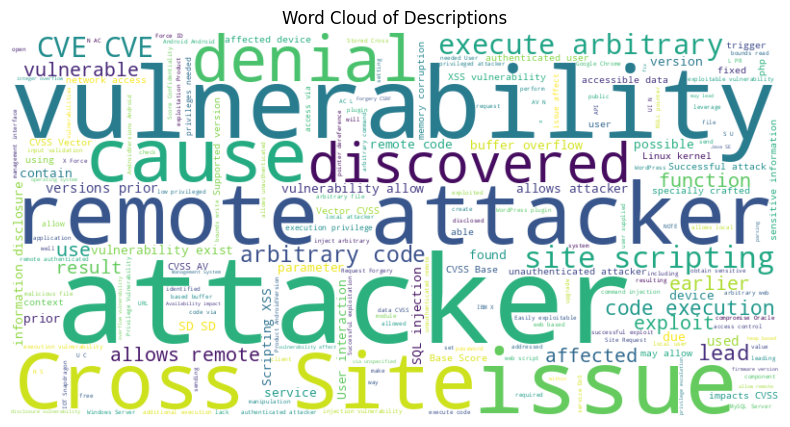

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text in the 'Description' column
text = " ".join(df["Description"].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axes
plt.title("Word Cloud of Descriptions")
plt.show()

## More Feature Engineering

Now that we've plotted  let's proceed with more feature engineering.

### Format Datetime columns

Split datetime columns in separate columns for year, month and day plus calculated columns, such as `Days_since_published`.

In [22]:
# Convert datetime columns to pandas datetime format
df['Published_Date'] = pd.to_datetime(df['Published_Date'])
df['Last_Modified_Date'] = pd.to_datetime(df['Last_Modified_Date'])

# Extract year, month, day, and other features from the datetime
df['Published_Year'] = df['Published_Date'].dt.year
df['Published_Month'] = df['Published_Date'].dt.month
df['Published_Day'] = df['Published_Date'].dt.day
df['Last_Modified_Year'] = df['Last_Modified_Date'].dt.year
df['Last_Modified_Month'] = df['Last_Modified_Date'].dt.month
df['Last_Modified_Day'] = df['Last_Modified_Date'].dt.day

# Calculate the difference between dates
df['Days_since_published'] = (df['Last_Modified_Date'] - df['Published_Date']).dt.days

# Drop timestamp columns
df = df.drop(columns=["Published_Date", "Last_Modified_Date"])

### Encode Categorical Columns



In [23]:
# Encode the categories as numbers for classification models
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["Severity",
                    "Problem_Type",
                    "Vuln_Status",
                    "Source_Identifier",
                    "Affected_Vendors",
                    "Vendors_Processed"
                    ]

for col in categorical_cols:
    df[col] = df[col].astype(str)
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])
    df[col] = df[col].astype('category')

df.head()

,Severity,Description,Problem_Type,Vuln_Status,Source_Identifier,Time_Delta_Days,Affected_Products_Count,Affected_Vendors,Config_Operators_AND,Config_Operators_OR,...,Versions_All,Versions_Count,Year,Published_Year,Published_Month,Published_Day,Last_Modified_Year,Last_Modified_Month,Last_Modified_Day,Days_since_published
97,1,SkyStream EMR5000 1.16 through 1.18 does not d...,2849,1,80,7995,3,17388,0,1,...,0,3,2002,2002,12,31,2024,11,20,7995
100,3,Sharp Zaurus PDA SL-5000D and SL-5500 uses a s...,2204,1,80,7995,2,17041,2,4,...,1,0,2002,2002,12,31,2024,11,20,7995
113,1,phpRank 1.8 stores the administrative password...,2128,1,80,7995,1,15077,0,1,...,0,1,2002,2002,12,31,2024,11,20,7995
172,0,The decompression algorithm in zlib 1.1.3 and ...,2667,1,80,8286,1,20998,0,1,...,1,0,2002,2002,3,15,2024,11,20,8286
266,1,The Network Attached Storage (NAS) Administrat...,2154,1,80,7995,1,10471,1,2,...,1,0,2002,2002,12,31,2024,11,20,7995


### Description Text Cleaning

Clean and lemmatize the Description column with nltk library:

In [24]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from joblib import Parallel, delayed

# Download required NLP resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Initialize NLP tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    words = word_tokenize(text)  # Tokenize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization & stopword removal
    return " ".join(words)

# Function to clean a DataFrame column in parallel
def clean_column_parallel(df_column):
    return Parallel(n_jobs=-1)(delayed(clean_text)(x) for x in df_column)

# Parallelizing the operations
df["Description"] = clean_column_parallel(df["Description"])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Rebalance Data with SMOTE

We add a method for rebalancing training data using SMOTE

In [25]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

def rebalance_data(X_train, y_train, seed):
    smote = SMOTE(sampling_strategy='auto', random_state=seed)  # 'auto' balances all classes
    X_res, y_res = smote.fit_resample(X_train, y_train)
    print("Rebalancing data with SMOTE...")

    return X_res, y_res

## ML Baseline Models 

We now proceed to train few baseline ML models that we will use for performance benchmarking. Specicifically we will implement:

- Dummy Classifier
- Logistic Regressor
- Random Forest Classifier
- XGBoost Classifier

In [26]:
histories = []  # Store training histories
model_names = []

### Create Dataframe

### Prepare Train, Test and Validation sets

In [27]:
from sklearn.model_selection import train_test_split

# Features (X) and target (y)
X = df.drop(columns=["Severity", "Description"])
y = df["Severity"]

### Remove columns with low importance

We now leverage the Random Forest classifier to compute feature importances, then filters out features with importance below a a custom threshold, keeping only the most relevant ones in our dataset.

In [28]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)
importances = model.feature_importances_

In [29]:
# Set threshold
threshold = 0.05

# Keep only important features
important_columns = X.columns[importances >= threshold]

# Drop unimportant features directly from X
X = X[important_columns]

In [30]:
# Split data (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 112408, Validation size: 14051, Test size: 14051


### Build and Train Baseline Models


In [31]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

# Scale numerical features using StandardScaler before training models
numerical_cols = X_train.select_dtypes(include=np.number).columns
X_train[numerical_cols] = X_train[numerical_cols].replace([np.inf, -np.inf, np.nan], 0)
X_test[numerical_cols] = X_test[numerical_cols].replace([np.inf, -np.inf, np.nan], 0)

# Rebalance data
X_train, y_train = rebalance_data(X_train, y_train, 42)

# Create a dictionary to store the results
results = {
    'Model': [],
    'Accuracy': [],
    'F1 Score': [],
    'Macro F1 Score': [],
    'Run Time': []
}

Rebalancing data with SMOTE...


#### Dummy Classifier

In [32]:
import time
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

# Dummy Classifier (Baseline Model)
dummy_clf = DummyClassifier(strategy='most_frequent')

# Start timing
start_time = time.time()

# Fit and predict
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

# End timing
end_time = time.time()
run_time = end_time - start_time

# Log results
results['Model'].append('Dummy Classifier')
results['Accuracy'].append(accuracy_score(y_test, y_pred_dummy))
results['F1 Score'].append(f1_score(y_test, y_pred_dummy, average='weighted'))
results['Macro F1 Score'].append(f1_score(y_test, y_pred_dummy, average='macro'))
results['Run Time'].append(run_time)

#### Logistic Regression

In [33]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)

# Start timing
start_time = time.time()

# Impute missing values before fitting the model
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Fit and predict
lr_model.fit(X_train_imputed, y_train)
y_pred_lr = lr_model.predict(X_test_imputed)

# End timing
end_time = time.time()
run_time = end_time - start_time

# Log results
results['Model'].append('Logistic Regression')
results['Accuracy'].append(accuracy_score(y_test, y_pred_lr))
results['F1 Score'].append(f1_score(y_test, y_pred_lr, average='weighted'))
results['Macro F1 Score'].append(f1_score(y_test, y_pred_lr, average='macro'))
results['Run Time'].append(run_time)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Random Forest Classifier

In [34]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=50)

# Start timing
start_time = time.time()

# Fit and predict
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# End timing
end_time = time.time()
run_time = end_time - start_time

# Log results
results['Model'].append('Random Forest')
results['Accuracy'].append(accuracy_score(y_test, y_pred_rf))
results['F1 Score'].append(f1_score(y_test, y_pred_rf, average='weighted'))
results['Macro F1 Score'].append(f1_score(y_test, y_pred_rf, average='macro'))
results['Run Time'].append(run_time)

#### XGBoost Classifier

In [35]:
import time
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score

# XGBoost Classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax',
                              num_class=len(set(y_train)),
                              eval_metric='mlogloss',
                              enable_categorical=True)

# Start timing
start_time = time.time()

# Fit and predict
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# End timing
end_time = time.time()
run_time = end_time - start_time  # Calculate run time

# Log results
results['Model'].append('XGBoost')
results['Accuracy'].append(accuracy_score(y_test, y_pred_xgb))
results['F1 Score'].append(f1_score(y_test, y_pred_xgb, average='macro'))
results['Macro F1 Score'].append(f1_score(y_test, y_pred_xgb, average='weighted'))
results['Run Time'].append(run_time)

## Deep Neural Models

### Multi Layer Perceptron (MLP)

#### Model Summary
- **Input Features:** Numerical columns from the dataset (excluding `Severity` and `Description`)
- **Labels:** `Severity` column (4-class classification)
- **Scaling:** `StandardScaler` applied to all numerical features
- **Data Split:** `80% Train/20% Test` (with further 80%/20% Train/Validation)
- **Random Seeds:** 3  Random seeds used for robustness
---

#### Model Architecture

| Layer Type         | Configuration                                   |
|--------------------|--------------------------------------------------|
| Dense              | 256 units                                        |
| BatchNormalization | —                                                |
| Activation         | ReLU                                             |
| Dropout            | 0.4                                              |
| Dense              | 512 units                                        |
| BatchNormalization | —                                                |
| Activation         | ReLU                                             |
| Dropout            | 0.2                                              |
| Dense              | 512 units                                        |
| BatchNormalization | —                                                |
| Activation         | ReLU                                             |
| Output Layer       | Dense(4), `softmax` activation                   |

---

#### Training Configuration
- **Loss Function:** `sparse_categorical_crossentropy`
- **Optimizer:** Adam (`learning_rate = 0.01`)
- **Batch Size:** 512
- **Epochs:** 50

---

#### Callbacks
- `EarlyStopping` (patience: 3)
- `LearningRateScheduler` (decay LR by 3% every epoch)

---

#### Evaluation
- Metrics tracked: **Accuracy**, **F1 Score**, **Macro F1 Score**
- Evaluation performed on the test set after training
- Final results aggregated as averages across all seed runs


In [36]:
seeds = [42, 100, 2010]

In [37]:
from sklearn.metrics import f1_score

def evaluate_model(X_test, y_test, model):
  y_pred = model.predict(X_test)
  y_true = y_test

  # Convert y_pred to predicted class labels (integers)
  y_pred_labels = np.argmax(y_pred, axis=1) # Get the index of the maximum value (predicted class) for each sample

  # Ensure y_true contains integer labels
  y_true_labels = y_true.codes if hasattr(y_true, 'codes') else y_true.astype(int)

  # Calculate accuracy and F1 score
  accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

  # Calculate f1 scores
  f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
  macro_f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

  return accuracy, f1, macro_f1

In [38]:
# Learning rate scheduler (linear decay)
def lr_scheduler(epoch, lr, percent=0.98):
    return lr * percent  # Reduce LR by percent every epoch

In [39]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, model_name):
    # Create a figure with 1 row and 2 columns for side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Set the main title
    fig.suptitle(model_name, fontsize=16)

    # Plot training and validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.show()

#### Model Training

In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from functools import partial

model_name = "Multilayer Perceptron (MLP)"

# Set hyperparameters
learning_rate = 0.001  # Learning rate
patience = 5          # Early stopping patience
epochs = 50           # Epochs to train

# Data structs to track performance metrics
accuracies = []
f1s = []
macro_f1s = []
run_times = []

for seed in seeds:
  print("-"*30)
  print(f"Running with seed: {seed}")

  # Set random seed for reproducibility
  np.random.seed(seed)
  tf.random.set_seed(seed)

  # numerical columns
  excluded_columns = ["Severity", "Description"]
  num_cols = [col for col in df.columns if col not in excluded_columns]

  # Numerical/encoded features
  X_num = df[num_cols].values

  # Labels (multi-class classification)
  y = df["Severity"].values

  # Split into train, validation, and test sets
  X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=seed)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

  # Scale features
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_val = scaler.transform(X_val)
  X_test = scaler.transform(X_test)

  # Rebalance data -> this doesn't seem to improve performance
  #X_train, y_train = rebalance_data(X_train, y_train, seed)

  print(f"Train size: {X_train.shape}, Validation size: {X_val.shape}, Test size: {X_test.shape}")

  # Early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

  # Learning rate scheduler (linear decay)
  lr_scheduler_fn = partial(lr_scheduler, percent=0.98)
  lr_callback = LearningRateScheduler(lr_scheduler_fn)

  # Define input layers
  num_input = Input(shape=(X_train.shape[1],))

  # Dense layers for numerical inputs
  x = Dense(512)(num_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(512)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(512)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  output = Dense(4, activation='softmax')(x)

  # Compile the model with Adam optimizer
  optimizer = Adam(learning_rate=learning_rate)

  # Define model
  model = Model(inputs=[num_input], outputs=output, name="baseline_deep_neural_network")

  # Compile model for multi-class classification
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # Start timing
  start_time = time.time()

  # Train model with early stopping and learning rate scheduler
  history = model.fit(
      X_train,
      y_train,
      validation_data=(X_val, y_val),
      epochs=epochs,
      batch_size=512,
      callbacks=[early_stopping, lr_callback]
  )

  # End timing
  end_time = time.time()
  run_time = end_time - start_time  # Calculate run time

  # Evaluate model
  print("Evaluating model...")
  accuracy, f1, macro_f1 = evaluate_model(X_test, y_test, model)
  accuracies.append(accuracy)
  f1s.append(f1)
  macro_f1s.append(macro_f1)
  run_times.append(run_time)

# Append results to the dictionary with averages
results['Model'].append(model_name)
results['Accuracy'].append(np.mean(accuracies))
results['F1 Score'].append(np.mean(f1s))
results['Macro F1 Score'].append(np.mean(macro_f1s))
results['Run Time'].append(np.mean(run_times))

# Append only last history
histories.append(history)

2025-05-29 08:11:25.448610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748506285.648816      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748506285.708442      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


------------------------------
Running with seed: 42
Train size: (89926, 84), Validation size: (22482, 84), Test size: (28102, 84)


I0000 00:00:1748506298.266646      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748506298.267233      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 84))
  warnings.warn(msg)
I0000 00:00:1748506302.785878     112 service.cc:148] XLA service 0x7cd834010c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748506302.786303     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748506302.786322     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748506303.159081     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


 57/176 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5027 - loss: 1.1301

I0000 00:00:1748506305.348718     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5459 - loss: 1.0092 - val_accuracy: 0.5939 - val_loss: 0.8557 - learning_rate: 9.8000e-04
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5975 - loss: 0.8604 - val_accuracy: 0.6068 - val_loss: 0.8401 - learning_rate: 9.6040e-04
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6108 - loss: 0.8440 - val_accuracy: 0.6082 - val_loss: 0.8392 - learning_rate: 9.4119e-04
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6159 - loss: 0.8320 - val_accuracy: 0.6158 - val_loss: 0.8270 - learning_rate: 9.2237e-04
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6204 - loss: 0.8236 - val_accuracy: 0.6181 - val_loss: 0.8217 - learning_rate: 9.0392e-04
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6246 - loss: 0.8155 - val_accuracy: 0.6238 - val_loss: 0.8178 - learning_rate: 8.8584e-04
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6306 - 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 84))
  warnings.warn(msg)


879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
------------------------------
Running with seed: 100
Train size: (89926, 84), Validation size: (22482, 84), Test size: (28102, 84)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_13']
Received: inputs=Tensor(shape=(None, 84))
  warnings.warn(msg)


176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5474 - loss: 1.0053 - val_accuracy: 0.5918 - val_loss: 0.8648 - learning_rate: 9.8000e-04
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.8616 - val_accuracy: 0.6084 - val_loss: 0.8463 - learning_rate: 9.6040e-04
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6086 - loss: 0.8438 - val_accuracy: 0.6101 - val_loss: 0.8479 - learning_rate: 9.4119e-04
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6170 - loss: 0.8317 - val_accuracy: 0.6195 - val_loss: 0.8328 - learning_rate: 9.2237e-04
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6234 - loss: 0.8217 - val_accuracy: 0.6212 - val_loss: 0.8281 - learning_rate: 9.0392e-04
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6280 - loss: 0.8152 - val_accuracy: 0.6232 - val_loss: 0.8279 - learning_rate: 8.8584e-04
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6306 - l

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_13']
Received: inputs=Tensor(shape=(32, 84))
  warnings.warn(msg)


879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
------------------------------
Running with seed: 2010
Train size: (89926, 84), Validation size: (22482, 84), Test size: (28102, 84)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_26']
Received: inputs=Tensor(shape=(None, 84))
  warnings.warn(msg)


176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5564 - loss: 0.9834 - val_accuracy: 0.5841 - val_loss: 0.8803 - learning_rate: 9.8000e-04
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5973 - loss: 0.8634 - val_accuracy: 0.6043 - val_loss: 0.8412 - learning_rate: 9.6040e-04
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6055 - loss: 0.8461 - val_accuracy: 0.6129 - val_loss: 0.8307 - learning_rate: 9.4119e-04
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6135 - loss: 0.8337 - val_accuracy: 0.6139 - val_loss: 0.8262 - learning_rate: 9.2237e-04
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6194 - loss: 0.8238 - val_accuracy: 0.6207 - val_loss: 0.8224 - learning_rate: 9.0392e-04
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6238 - loss: 0.8164 - val_accuracy: 0.6218 - val_loss: 0.8180 - learning_rate: 8.8584e-04
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6276 - l

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_26']
Received: inputs=Tensor(shape=(32, 84))
  warnings.warn(msg)


879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


#### Plot Results

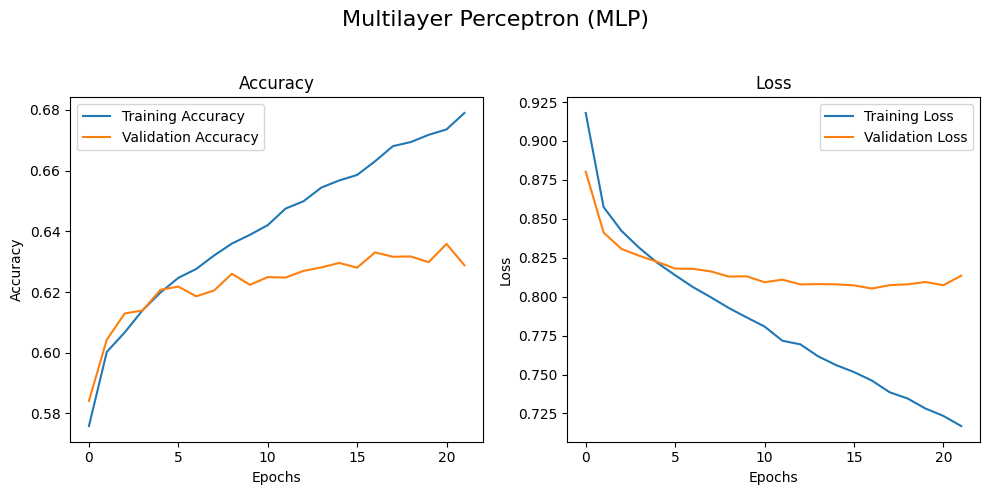

In [41]:
plot_learning_curves(history, model_name)

### Embedding-Only Deep Neural Network (LSTM)

#### Model Summary
- **Input Features:** Tokenized text from the `Description` column (no numerical features used)
- **Labels:** `Severity` column (4-class classification)
- **Text Preprocessing:**
  - Tokenizer vocabulary size limited to 5,000 words
  - Sequences padded to a fixed length of 100 tokens
- **Data Split:** `80% Train/20% Test` (with further 80%/20% Train/Validation)
- **Random Seeds:** 3 Random seeds used for robustness

---

#### Model Architecture

| Layer Type         | Configuration                                      |
|--------------------|-----------------------------------------------------|
| Input              | Sequence input of length 100                        |
| Embedding          | Vocab size = 5,000, Embedding dim = 50              |
| LSTM               | 128 units, returns final hidden state               |
| Dropout            | 0.3                                                 |
| Dense              | 128 units, ReLU activation                          |
| Output Layer       | Dense(4), `softmax` activation                      |

---

#### Training Configuration
- **Loss Function:** `sparse_categorical_crossentropy`
- **Optimizer:** Adam (`learning_rate = 0.01`)
- **Batch Size:** 512
- **Epochs:** 20

---

#### Callbacks
- `EarlyStopping` (patience = 2)
---

#### Evaluation
- Metrics tracked: **Accuracy**, **F1 Score**, **Macro F1 Score**
- Evaluation performed on the test set after training
- Final results aggregated as averages across all seed runs
- **Training Time** measured and averaged across all runs


#### Model Training

In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score
from functools import partial
import time

model_name = "Embedding-Only (LSTM)"

# Set hyperparameters
max_vocab = 5000        # Max vocabulary size
max_len = 100           # Max sequence length
embedding_dim = 50      # Embedding vector dimension
learning_rate = 0.01    # Learning rate
patience = 3            # Early stopping patience
epochs = 20             # Epochs to train

# Data structs to track performance metrics
accuracies = []
f1s = []
run_times = []
macro_f1s = []

# Tokenizer setup
tokenizer = Tokenizer(num_words=max_vocab, oov_token="")
tokenizer.fit_on_texts(df["Description"])

# Encode labels
y = df["Severity"].values

for seed in seeds:
    print("-"*30)
    print(f"Running with seed: {seed}")

    # Set seed
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Tokenize and pad descriptions
    X_text = tokenizer.texts_to_sequences(df["Description"])
    X_text = pad_sequences(X_text, maxlen=max_len, padding='post')

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

    # Rebalance data
    X_train, y_train = rebalance_data(X_train, y_train, seed)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Linear decay callback
    lr_scheduler_fn = partial(lr_scheduler, percent=0.95)
    lr_callback = LearningRateScheduler(lr_scheduler_fn)

    # Model architecture
    input_desc = Input(shape=(max_len,), name="desc_input")
    x = Embedding(input_dim=max_vocab, output_dim=embedding_dim)(input_desc)
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(128, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    output = Dense(4, activation='softmax')(x)  # 4-class output

    model = Model(inputs=input_desc, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Start timing
    start_time = time.time()

    # Train
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=512,
        callbacks=[early_stopping, lr_callback],
        verbose=1
    )

    # End timing
    end_time = time.time()
    run_time = end_time - start_time  # Calculate run time

    # Evaluate
    accuracy, f1, macro_f1 = evaluate_model(X_test, y_test, model)

    accuracies.append(accuracy)
    f1s.append(f1)
    macro_f1s.append(macro_f1)
    run_times.append(run_time)

# Log final results
results['Model'].append(model_name)
results['Accuracy'].append(np.mean(accuracies))
results['F1 Score'].append(np.mean(f1s))
results['Macro F1 Score'].append(np.mean(macro_f1s))
results['Run Time'].append(np.mean(run_times))
histories.append(history)

------------------------------
Running with seed: 42
Rebalancing data with SMOTE...
Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.2762 - loss: 1.3678 - val_accuracy: 0.4330 - val_loss: 1.1312 - learning_rate: 0.0095
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.5503 - loss: 0.9488 - val_accuracy: 0.6835 - val_loss: 0.7363 - learning_rate: 0.0090
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.6929 - loss: 0.7023 - val_accuracy: 0.7032 - val_loss: 0.6987 - learning_rate: 0.0086
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.7260 - loss: 0.6317 - val_accuracy: 0.7203 - val_loss: 0.6618 - learning_rate: 0.0081
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7497 - loss: 0.5841 - val_accuracy: 0.7243 - val_loss: 0.6645 - learning_rate: 0.0077
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7665 - loss: 0.5514 - val_accuracy: 0.7247 - val_loss: 0.6555 - learning_rate:

#### Plot Results

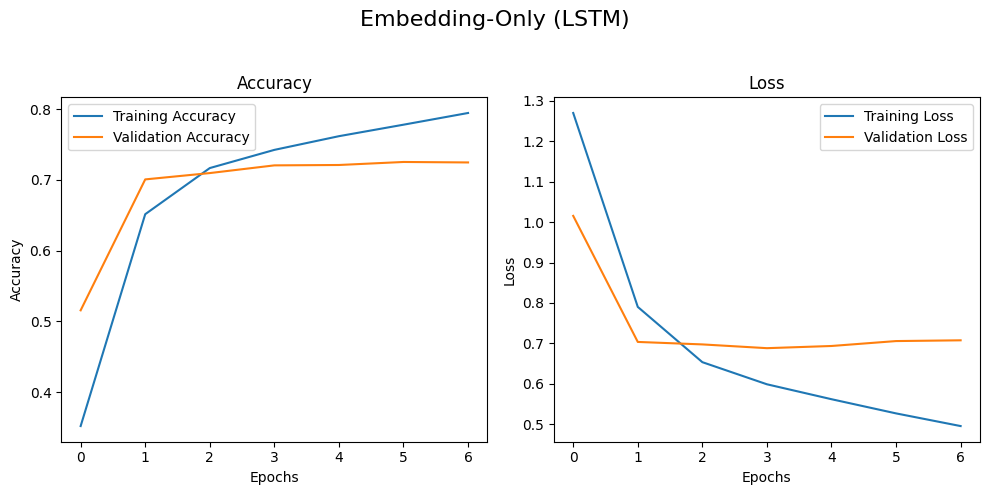

In [43]:
plot_learning_curves(history, model_name)

### Embedding-Only Deep Neural Network (roberta-base + Transformer)

#### Model Summary
- **Input Features:** Sentence embeddings from `Description` column using `roberta-base`
- **Labels:** `Severity` column (4-class classification)
- **Text Preprocessing & Embedding:**
  - Tokenized using Hugging Face's `AutoTokenizer` (`roberta-base`)
  - Texts truncated/padded to max length 128
  - Sentence embeddings computed via **mean pooling** over the `last_hidden_state` output
  - Embedding dimension: 768
- **Device:** Embeddings computed using GPU if available (`torch.device`)
- **Data Split:** `80% Train/20% Test` (with further 80%/20% Train/Validation)
- **Random Seeds:** 3 Random seeds used for robustness

---

#### Model Architecture

| Layer Type         | Configuration                                      |
|--------------------|-----------------------------------------------------|
| Input              | Dense vector (shape = 768)                          |
| Dense              | 64 units, ReLU activation                           |
| BatchNormalization | —                                                   |
| Dropout            | 0.3                                                 |
| Dense              | 64 units, ReLU activation                           |
| Output Layer       | Dense(4), `softmax` activation                      |

---

#### Training Configuration
- **Loss Function:** `sparse_categorical_crossentropy`
- **Optimizer:** Adam (`learning_rate = 0.01`)
- **Batch Size:** 512
- **Epochs:** 20

---

#### Callbacks
- `EarlyStopping` (patience = 3)

---

#### Evaluation
- Metrics tracked: **Accuracy**, **F1 Score**, **Macro F1 Score**
- Evaluation performed on the test set after training
- Final results aggregated as averages across all seed runs
- **Training Time** measured and averaged across all runs


#### Model Training

In [44]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoTokenizer
import tensorflow as tf
import torch
import numpy as np

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = TFAutoModel.from_pretrained("roberta-base", trainable=True)  # Unfreeze weights

def mean_pooling(token_embeddings, attention_mask):
    # Convert attention_mask to tensorflow tensor
    attention_mask = tf.cast(attention_mask, tf.float32)

    # Ensure attention_mask has the same number of dimensions as token_embeddings
    attention_mask = tf.expand_dims(attention_mask, axis=-1)

    input_mask_expanded = attention_mask * token_embeddings

    sum_embeddings = tf.reduce_sum(input_mask_expanded, axis=1)
    sum_mask = tf.reduce_sum(attention_mask, axis=1)

    # Perform division using tf.math.divide_no_nan
    return tf.math.divide_no_nan(sum_embeddings, sum_mask)


def get_roberta_embeddings(texts, max_length=128, batch_size=512):
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        # Return tensorflow tensors
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

        # No need for torch.no_grad() with tensorflow model
        outputs = model(**inputs)

        batch_embeddings = mean_pooling(outputs.last_hidden_state, inputs["attention_mask"])
        all_embeddings.append(batch_embeddings.numpy())

    return np.vstack(all_embeddings)

cve_descriptions = df["Description"].tolist()
description_embeddings = get_roberta_embeddings(cve_descriptions, batch_size=512)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [45]:
import time
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score

X = description_embeddings
y = df["Severity"].values

model_name = "Embedding-Only (Transformer)"

# Data structs to track performance metrics
accuracies = []
f1s = []
run_times = []

# Parameters
learning_rate = 3e-5
patience = 3
epochs = 20  # Epochs to train

for seed in seeds:
    print("-" * 30)
    print(f"Running with seed: {seed}")

    # Set random seed for reproducibility
    np.random.seed(seed)
    tf.random.set_seed(seed)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

    # Rebalance data
    #X_train, y_train = rebalance_data(X_train, y_train, seed)

    # Input layer for embeddings
    text_input = Input(shape=(X_train.shape[1],), dtype=tf.float32, name="text_input")

    # Classification layers
    x = Dense(256, activation="relu")(text_input)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    output = Dense(4, activation="softmax")(x)

    # Create the model
    model = Model(inputs=text_input, outputs=output)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Early stoppint
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


    # Learning rate scheduler (linear decay)
    lr_scheduler_fn = partial(lr_scheduler, percent=0.98)
    lr_callback = LearningRateScheduler(lr_scheduler_fn)

    # Start timing
    start_time = time.time()

    # Train the model
    history = model.fit(
        X_train,  # Use precomputed embeddings for training
        y_train,
        batch_size=512,
        epochs=epochs,
        validation_data=(X_val, y_val),  # Validation data for early stopping
        callbacks=[early_stopping, lr_callback],
    )

    # End timing
    end_time = time.time()
    run_time = end_time - start_time  # Calculate run time

    # Evaluation
    accuracy, f1, macro_f1 = evaluate_model(X_test, y_test, model)

    accuracies.append(accuracy)
    f1s.append(f1)
    macro_f1s.append(macro_f1)
    run_times.append(run_time)

# Log final results
results['Model'].append(model_name)
results['Accuracy'].append(np.mean(accuracies))
results['F1 Score'].append(np.mean(f1s))
results['Macro F1 Score'].append(np.mean(macro_f1s))
results['Run Time'].append(np.mean(run_times))

histories.append(history)

------------------------------
Running with seed: 42
Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3047 - loss: 1.5746 - val_accuracy: 0.4827 - val_loss: 1.3242 - learning_rate: 2.9400e-05
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4371 - loss: 1.3098 - val_accuracy: 0.5417 - val_loss: 1.2167 - learning_rate: 2.8812e-05
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4906 - loss: 1.2147 - val_accuracy: 0.5583 - val_loss: 1.1250 - learning_rate: 2.8236e-05
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5269 - loss: 1.1489 - val_accuracy: 0.5729 - val_loss: 1.0640 - learning_rate: 2.7671e-05
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5442 - loss: 1.1042 - val_accuracy: 0.5844 - val_loss: 1.0210 - learning_rate: 2.7118e-05
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5595 - loss: 1.0648 - val_accuracy: 0.5932 - val_loss: 0.9930 - learning_rate: 2.6575e-05
Epoch 7/20

#### Plot Results

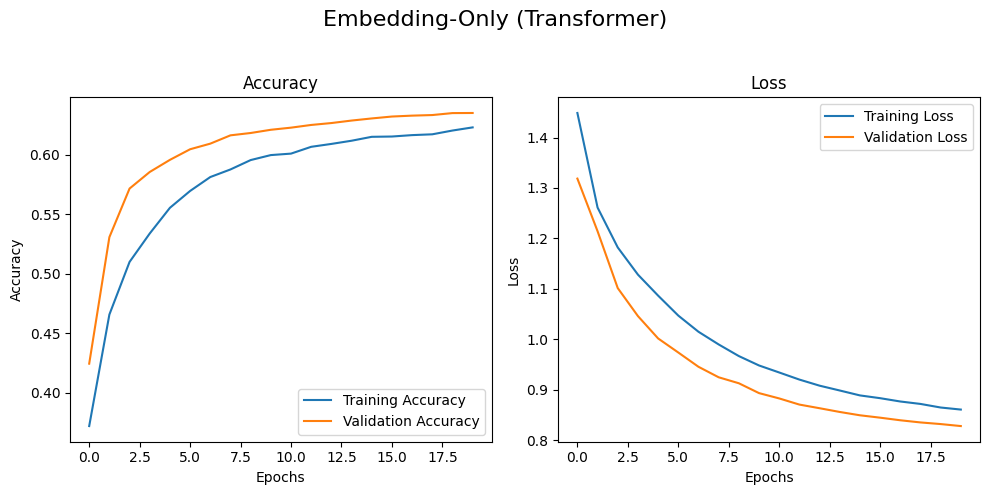

In [46]:
plot_learning_curves(history, model_name)

### Hybrid Multilayer Perceptron (MLP) with LSTM

#### Model Summary
- **Input Features:**
  - **Text Input:** `Description` column (tokenized and padded sequences)
  - **Numerical Input:** All other columns except `Severity` and `Description`
- **Output Labels:** `Severity` (4-class classification)
- **Vocabulary Size:** 5000 (`max_vocab`)
- **Max Sequence Length:** 100 (`max_len`)
- **Embedding Dimension:** 100 (`embedding_dim`)

---

#### Data Preprocessing
- Tokenized using Keras `Tokenizer`
- Description text sequences padded to `max_len`
- Numerical features extracted directly from dataframe
- Combined input: `[padded_text_sequence | numerical_features]`
- Train/Val/Test split:
  - Train: 64%, Validation: 16%, Test: 20%
- Multiple random seeds used for robustness

---

#### Model Architecture

| Component            | Description                                                  |
|----------------------|--------------------------------------------------------------|
| **Text Input**       | Shape = (100,)                                               |
| **Embedding Layer**  | Output dim = 100, input dim = 5000                           |
| **LSTM Layer**       | 64 units                                                     |
| **BatchNorm (LSTM)** | Applied after LSTM output                                    |
| **Numerical Input**  | Shape = (#num_cols,)                                         |
| **Dense Block 1**    | 2048 units → BatchNorm → ReLU → Dropout(0.5)                 |
| **Dense Block 2**    | 2048 units → BatchNorm → ReLU → Dropout(0.5)                 |
| **Dense Block 3**    | 2048 units → BatchNorm → ReLU → Dropout(0.3)                 |
| **Concatenation**    | `[LSTM output \| DNN output]`                                 |
| **Output Layer**     | Dense(4), Softmax                                            |

---

#### Training Configuration
- **Loss Function:** `sparse_categorical_crossentropy`
- **Optimizer:** Adam (`learning_rate = 0.01`)
- **Batch Size:** 512
- **Epochs:** 20

---

#### Callbacks
- `EarlyStopping` (patience = 3)
- `LearningRateScheduler`: decays learning rate by 5% every epoch

---

#### Evaluation
- Metrics tracked: **Accuracy**, **F1 Score**
- Evaluation performed on the test set after training
- Final results averaged across all seed runs
- **Training Time** measured and averaged across all runs


#### Model Training

In [47]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Dropout, LSTM, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import accuracy_score, f1_score

model_name = "Hybrid MLP-LSTM"

# Set hyperparameters
max_vocab = 5000      # Max vocabulary size for text
max_len = 100         # Max sequence length
embedding_dim = 100    # Embedding output dimension
learning_rate = 0.01  # Learning rate
patience = 3          # Early stopping patience
epochs = 20           # Epochs to train

# Data structures to store performance metrics
accuracies = []
f1s = []
macro_f1s = []
run_times = []

for seed in seeds:
    print("-" * 30)
    print(f"Running with seed: {seed}")

    # Set random seed for reproducibility
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Numerical columns
    excluded_columns = ["Severity", "Description"]
    text_cols = ["Description"]
    num_cols = [col for col in df.columns if col not in excluded_columns]

    # Tokenization and Padding
    tokenizer = Tokenizer(num_words=max_vocab, oov_token="")
    tokenizer.fit_on_texts(df["Description"])

    X_text = pad_sequences(tokenizer.texts_to_sequences(df["Description"]), maxlen=max_len, padding='post')

    # Numerical/encoded features
    X_num = df[num_cols].values

    # Concatenate text and numerical features
    X_combined = np.concatenate([X_text, X_num], axis=1)

    # Labels (multi-class classification)
    y = df["Severity"].values

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

    # lr decay callback
    lr_scheduler_fn = partial(lr_scheduler, percent=0.98)
    lr_callback = LearningRateScheduler(lr_scheduler_fn)

    # Define input layers
    text_input = Input(shape=(max_len,), name="text_input")  # Text sequences
    num_input = Input(shape=(X_num.shape[1],), name="num_input")  # Numerical features

    # Text branch
    x_text = Embedding(max_vocab, embedding_dim)(text_input)
    x_text = LSTM(128, return_sequences=True)(x_text)
    x_text = Dropout(0.3)(x_text)
    x_text = LSTM(128, return_sequences=False)(x_text)
    x_text = Dropout(0.2)(x_text)

    # Numerical branch
    x_num = Dense(512)(num_input)
    x_num = BatchNormalization()(x_num)
    x_num = Activation('relu')(x_num)
    x_num = Dropout(0.5)(x_num)

    x_num = Dense(512)(num_input)
    x_num = BatchNormalization()(x_num)
    x_num = Activation('relu')(x_num)
    x_num = Dropout(0.2)(x_num)

    x_num = Dense(512)(num_input)
    x_num = BatchNormalization()(x_num)
    x_num = Activation('relu')(x_num)

    # Concatenate branches
    combined = Concatenate()([x_text, x_num])

    # Final layers
    output = Dense(4, activation='softmax')(combined)

    # Build model
    model = Model(inputs=[text_input, num_input], outputs=output)

    # Split into train (80%) and temp (20%)
    X_text_train, X_text_temp, X_num_train, X_num_temp, y_train, y_temp = train_test_split(
        X_text, X_num, y,
        test_size=0.2,
        random_state=seed
    )

    # Split temp into validation (10%) and test (10%)
    X_text_val, X_text_test, X_num_val, X_num_test, y_val, y_test = train_test_split(
        X_text_temp, X_num_temp, y_temp,
        test_size=0.5,
        random_state=seed
    )

    # Rebalance data - Apply SMOTE to both text and numerical features together
    X_combined_train = np.concatenate([X_text_train, X_num_train], axis=1)
    X_combined_train, y_train = rebalance_data(X_combined_train, y_train, seed)

    # Separate back into text and numerical after SMOTE
    X_text_train = X_combined_train[:, :X_text_train.shape[1]]  # Text features
    X_num_train = X_combined_train[:, X_text_train.shape[1]:]   # Numerical features

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)

    # Define model - Use the original text_input
    model = Model(inputs=[text_input, num_input], outputs=output, name="combined_deep_neural_network")

    # Compile model for multi-class classification
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Start timing
    start_time = time.time()

    # Train model with early stopping and learning rate scheduler
    history =  model.fit(
          [X_text_train, X_num_train],  # Explicit separate inputs
          y_train,
          validation_data=([X_text_val, X_num_val], y_val),
          epochs=epochs,
          batch_size=512,
          callbacks=[early_stopping, lr_callback]
      )

    # End timing
    end_time = time.time()
    run_time = end_time - start_time  # Calculate run time

    # Evaluate model
    print("Evaluating model...")
    accuracy, f1, macro_f1 = evaluate_model([X_text_test, X_num_test], y_test, model)

    accuracies.append(accuracy)
    f1s.append(f1)
    macro_f1s.append(macro_f1)
    run_times.append(run_time)

# Append results to the dictionary with averages
results['Model'].append(model_name)
results['Accuracy'].append(np.mean(accuracies))
results['F1 Score'].append(np.mean(f1s))
results['Macro F1 Score'].append(np.mean(macro_f1s))
results['Run Time'].append(np.mean(run_times))  # Store the average run time

# Append only last history
histories.append(history)

------------------------------
Running with seed: 42
Rebalancing data with SMOTE...
Epoch 1/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.3858 - loss: 1.3393 - val_accuracy: 0.6212 - val_loss: 0.8913 - learning_rate: 0.0098
Epoch 2/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.6884 - loss: 0.7458 - val_accuracy: 0.6923 - val_loss: 0.7255 - learning_rate: 0.0096
Epoch 3/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7371 - loss: 0.6319 - val_accuracy: 0.7155 - val_loss: 0.6763 - learning_rate: 0.0094
Epoch 4/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.7619 - loss: 0.5783 - val_accuracy: 0.7180 - val_loss: 0.6820 - learning_rate: 0.0092
Epoch 5/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.7771 - loss: 0.5463 - val_accuracy: 0.7283 - val_loss: 0.6612 - learning_rate: 0.0090
Epoch 6/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7874 - loss: 0.5244 - val_accuracy: 0.7275 - val_loss: 0.6662 - learning_rate:

#### Plot Results

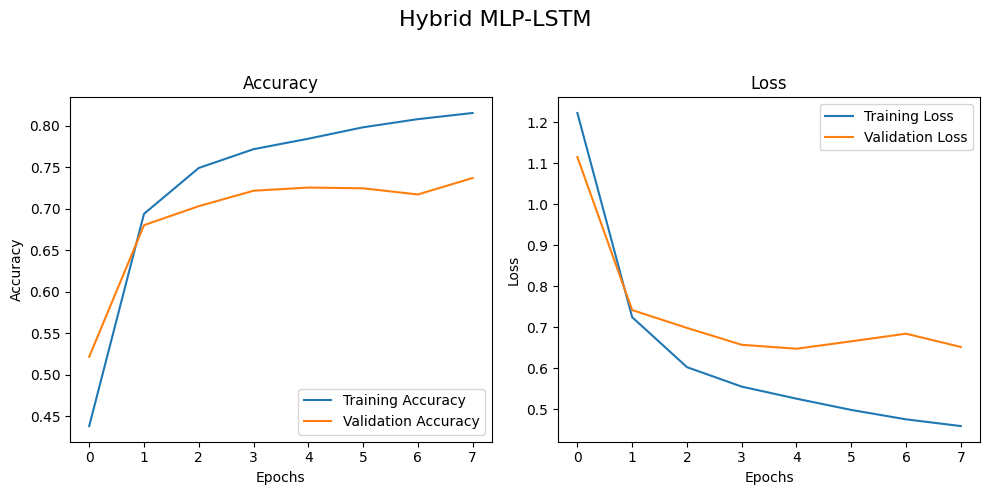

In [48]:
plot_learning_curves(history, model_name)

## Performance Review

Let's plot models performances we have tracked after training all models.

### Performance plots

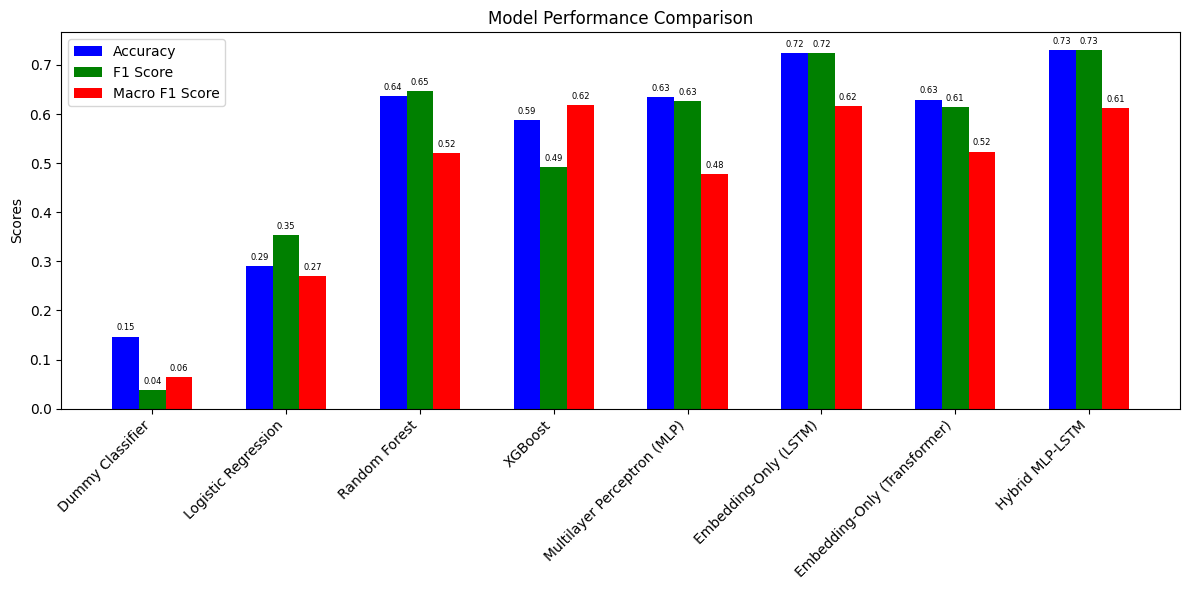

In [49]:
import matplotlib.pyplot as plt
import numpy as np

models = results['Model']
accuracy = results['Accuracy']
f1_score = results['F1 Score']
macro_f1_score = results['Macro F1 Score']

# Ensure all lists have the same length
num_models = len(models)
accuracy = accuracy[:num_models]
f1_score = f1_score[:num_models]
macro_f1_score = macro_f1_score[:num_models]


x = np.arange(num_models)  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size for better visibility

# Plot grouped bars with adjusted positions
rects1 = ax.bar(x - width, accuracy, width, label='Accuracy', color='blue')
rects2 = ax.bar(x, f1_score, width, label='F1 Score', color='green')
rects3 = ax.bar(x + width, macro_f1_score, width, label='Macro F1 Score', color='red')


# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")  # Rotate x-axis labels for readability
ax.legend()

# Function to autolabel bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=6)

# Autolabel each bar group
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

### Running times plots

{'Model': ['Dummy Classifier', 'Logistic Regression', 'Random Forest', 'XGBoost', 'Multilayer Perceptron (MLP)', 'Embedding-Only (LSTM)', 'Embedding-Only (Transformer)', 'Hybrid MLP-LSTM'], 'Accuracy': [0.1468222902284535, 0.289872606931891, 0.6364671553626077, 0.5870044836666429, 0.6339524984359741, 0.723732590675354, 0.6293620864550272, 0.7299124598503113], 'F1 Score': [0.03759394126117656, 0.3536350585970409, 0.6466426524418245, 0.49164559791859214, 0.625816766641328, 0.7240354819687228, 0.6136409841945416, 0.729803417299194], 'Macro F1 Score': [0.0640126597989326, 0.26947844655838826, 0.5205568333055335, 0.6178610511390271, 0.47842036318289066, 0.6157931620318161, 0.5233937852029367, 0.6120757280628796], 'Run Time': [0.005374431610107422, 47.77225995063782, 17.378905773162842, 22.882805585861206, 23.76623733838399, 103.52458588282268, 19.01205277442932, 149.84946378072104]}


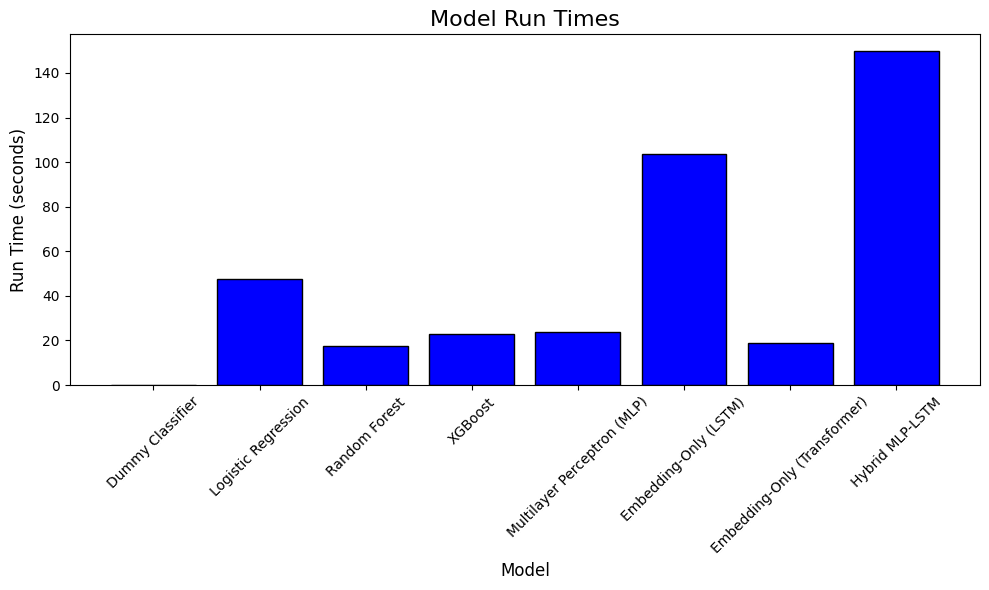

In [50]:
import matplotlib.pyplot as plt

print(results)
# Ensure both lists have the same length
models = results['Model']
run_times = results['Run Time']

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, run_times, color='blue', edgecolor='black')

# Adding titles and labels
plt.title('Model Run Times', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Run Time (seconds)', fontsize=12)
plt.xticks(rotation=45)  # Rotate model names if needed for better readability

# Show the plot
plt.tight_layout()
plt.show()

### Table of Results

In [51]:
# Create the results DataFrame, ensuring all columns have the same length
results_df = pd.DataFrame({
    'Model': results['Model'][:min(len(results['Model']), len(results['Accuracy']), len(results['F1 Score']), len(results['Run Time']))],
    'Accuracy': results['Accuracy'][:min(len(results['Model']), len(results['Accuracy']), len(results['F1 Score']), len(results['Run Time']))],
    'F1 Score': results['F1 Score'][:min(len(results['Model']), len(results['Accuracy']), len(results['F1 Score']), len(results['Run Time']))],
    'Macro F1 Score': results['Macro F1 Score'][:min(len(results['Model']), len(results['Accuracy']), len(results['Macro F1 Score']), len(results['Run Time']))],
    'Run Time': results['Run Time'][:min(len(results['Model']), len(results['Accuracy']), len(results['F1 Score']), len(results['Run Time']))]
})

# Display the results table
display(results_df)

,Model,Accuracy,F1 Score,Macro F1 Score,Run Time
0,Dummy Classifier,0.146822,0.037594,0.064013,0.005374
1,Logistic Regression,0.289873,0.353635,0.269478,47.772260
2,Random Forest,0.636467,0.646643,0.520557,17.378906
3,XGBoost,0.587004,0.491646,0.617861,22.882806
4,Multilayer Perceptron (MLP),0.633952,0.625817,0.478420,23.766237
5,Embedding-Only (LSTM),0.723733,0.724035,0.615793,103.524586
6,Embedding-Only (Transformer),0.629362,0.613641,0.523394,19.012053
7,Hybrid MLP-LSTM,0.729912,0.729803,0.612076,149.849464


## The End

<!-- | **Model**                | **Accuracy** | **F1 Score** |
|--------------------------|--------------|--------------|
| Dummy Classifier         | 0.419116     | 0.247560     |
| Logistic Regression      | 0.474984     | 0.428590     |
| Random Forest            | 0.654402     | 0.632665     |
| XGBoost                  | 0.705146     | 0.698958     |
| Deep Neural Network      | 0.xxxxxx     | 0.xxxxxx     |
| Single Embedding Network | 0.xxxxxx     | 0.xxxxxx     |
| Combined NLP/DL Network  | 0.xxxxxx     | 0.xxxxxx     | -->
